Shape detection based on vertex

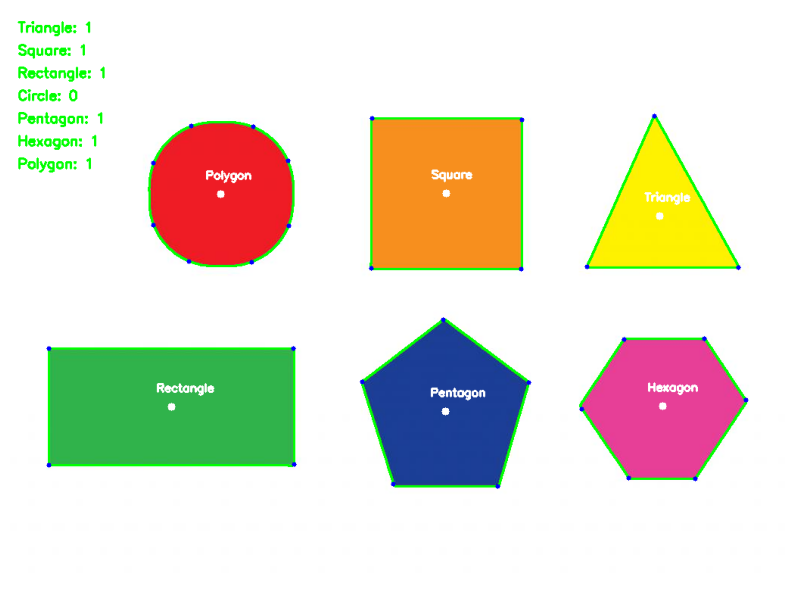

Detected shapes count:
Triangle: 1
Square: 1
Rectangle: 1
Circle: 0
Pentagon: 1
Hexagon: 1
Polygon: 1



In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_shapes(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or the path is incorrect")
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 240, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for contour in contours:
        # Approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.04 * peri, True)

        # If the shape has 3 vertices, it's a triangle
        if len(approx) == 3:
            shapes.append((contour, "Triangle", approx))
        # If the shape has 4 vertices, it's either a square or a rectangle
        elif len(approx) == 4:
            # Calculate aspect ratio
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h

            # If aspect ratio is close to 1, it's a square, otherwise a rectangle
            shape_type = "Square" if 0.95 <= aspect_ratio <= 1.05 else "Rectangle"
            shapes.append((contour, shape_type, approx))
        # If the shape has 5 vertices, it's a pentagon
        elif len(approx) == 5:
            shapes.append((contour, "Pentagon", approx))
        # If the shape has 6 vertices, it's a hexagon
        elif len(approx) == 6:
            shapes.append((contour, "Hexagon", approx))
        # If the shape has more than 6 vertices, it could be a circle or polygon
        else:
            # Use a simple heuristic: if the shape is very close to a circle
            area = cv2.contourArea(contour)
            (x, y), radius = cv2.minEnclosingCircle(contour)
            circle_area = np.pi * (radius ** 2)
            # Consider it a circle if the area difference is small and vertices are more than 8
            if abs(circle_area - area) < 0.5 * circle_area and len(approx) > 8:
                shapes.append((contour, "Circle", approx))
            else:
                shapes.append((contour, "Polygon", approx))

    return shapes, image

if __name__ == "__main__":
    image_path = "shape.jpg"  # Path to your image
    detected_shapes, image = detect_shapes(image_path)

    # Count shapes
    shape_counts = {"Triangle": 0, "Square": 0, "Rectangle": 0, "Circle": 0, "Pentagon": 0, "Hexagon": 0, "Polygon": 0}
    for contour, shape, _ in detected_shapes:
        shape_counts[shape] += 1

    # Annotate and mark the shapes
    for i, (contour, shape, vertices) in enumerate(detected_shapes):
        # Get the bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
        
        # Draw the contour
        cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
        
        # Draw a mark at each vertex
        for vertex in vertices:
            x, y = vertex.ravel()
            cv2.circle(image, (x, y), 3, (255, 0, 0), -1)
        
        # Draw a mark at the centroid
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(image, (cX, cY), 5, (255, 255, 255), -1)
            
            # Draw the name of the shape at the centroid
            cv2.putText(image, shape, (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    # Print the counts of each shape
    shape_count_text = "Detected shapes count:\n"
    y0, dy = 30, 30
    for i, (shape, count) in enumerate(shape_counts.items()):
        text = f"{shape}: {count}"
        shape_count_text += text + "\n"
        cv2.putText(image, text, (10, y0 + i * dy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Display the annotated image with matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Display the shape count text
    print(shape_count_text)


Mendeteksi trapesium, jajar genjang, belah ketupat, segitiga, segi panjang.
Namun jajar genjang masih terdeteksi sebagai trapesium.

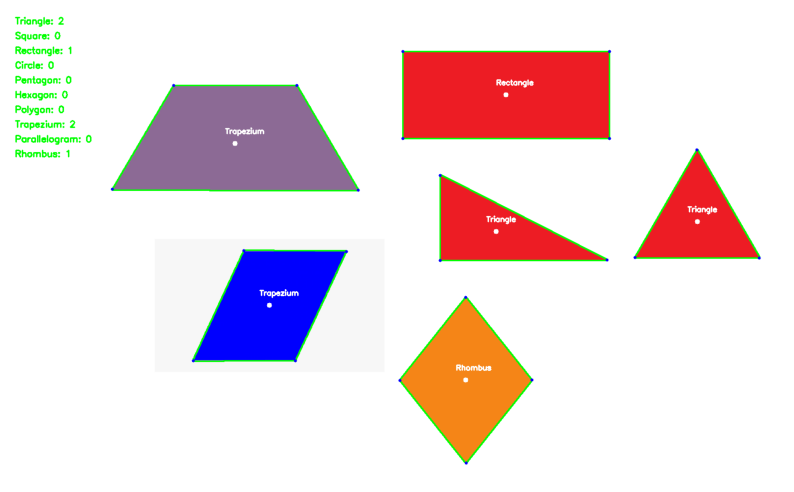

Detected shapes count:
Triangle: 2
Square: 0
Rectangle: 1
Circle: 0
Pentagon: 0
Hexagon: 0
Polygon: 0
Trapezium: 2
Parallelogram: 0
Rhombus: 1



In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def angle_between(v1, v2):
    v1 = v1.flatten()
    v2 = v2.flatten()
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_v1, unit_v2)
    angle = np.arccos(np.clip(dot_product, -1.0, 1.0))
    return np.degrees(angle)

def classify_quadrilateral(approx):
    # Get the side lengths
    side_lengths = [np.linalg.norm(approx[i] - approx[(i + 1) % 4]) for i in range(4)]
    # Get the angles
    angles = [angle_between(approx[i] - approx[(i - 1) % 4], approx[(i + 1) % 4] - approx[i]) for i in range(4)]
    
    # Sort side lengths and angles for easier comparison
    side_lengths.sort()
    angles = [angle % 180 for angle in angles]
    angles.sort()

    # Determine the type of quadrilateral
    if all(85 <= angle <= 95 for angle in angles):
        if np.allclose(side_lengths, side_lengths[0], atol=5):
            return "Square"
        else:
            return "Rectangle"
    elif np.allclose(side_lengths, side_lengths[0], atol=5):
        if not all(85 <= angle <= 95 for angle in angles):
            return "Rhombus"
        else:
            return "Square"
    elif len(set(np.round(angles, 1))) == 2:
        return "Parallelogram"
    else:
        return "Trapezium"

def detect_shapes(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or the path is incorrect")
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 240, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for contour in contours:
        # Approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.04 * peri, True)

        # If the shape has 3 vertices, it's a triangle
        if len(approx) == 3:
            shapes.append((contour, "Triangle", approx))
        # If the shape has 4 vertices, classify it further
        elif len(approx) == 4:
            shape_type = classify_quadrilateral(approx)
            shapes.append((contour, shape_type, approx))
        # If the shape has 5 vertices, it's a pentagon
        elif len(approx) == 5:
            shapes.append((contour, "Pentagon", approx))
        # If the shape has 6 vertices, it's a hexagon
        elif len(approx) == 6:
            shapes.append((contour, "Hexagon", approx))
        # If the shape has more than 6 vertices, it could be a circle or polygon
        else:
            # Use a simple heuristic: if the shape is very close to a circle
            area = cv2.contourArea(contour)
            (x, y), radius = cv2.minEnclosingCircle(contour)
            circle_area = np.pi * (radius ** 2)
            # Consider it a circle if the area difference is small and vertices are more than 8
            if abs(circle_area - area) < 0.5 * circle_area and len(approx) > 8:
                shapes.append((contour, "Circle", approx))
            else:
                shapes.append((contour, "Polygon", approx))

    return shapes, image

if __name__ == "__main__":
    image_path = "paint.png"  # Path to your image
    detected_shapes, image = detect_shapes(image_path)

    # Count shapes
    shape_counts = {"Triangle": 0, "Square": 0, "Rectangle": 0, "Circle": 0, "Pentagon": 0, "Hexagon": 0, "Polygon": 0, "Trapezium": 0, "Parallelogram": 0, "Rhombus": 0}
    for contour, shape, _ in detected_shapes:
        shape_counts[shape] += 1

    # Annotate and mark the shapes
    for i, (contour, shape, vertices) in enumerate(detected_shapes):
        # Get the bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
        
        # Draw the contour
        cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
        
        # Draw a mark at each vertex
        for vertex in vertices:
            x, y = vertex.ravel()
            cv2.circle(image, (x, y), 3, (255, 0, 0), -1)
        
        # Draw a mark at the centroid
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(image, (cX, cY), 5, (255, 255, 255), -1)
            
            # Draw the name of the shape at the centroid
            cv2.putText(image, shape, (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    # Print the counts of each shape
    shape_count_text = "Detected shapes count:\n"
    y0, dy = 30, 30
    for i, (shape, count) in enumerate(shape_counts.items()):
        text = f"{shape}: {count}"
        shape_count_text += text + "\n"
        cv2.putText(image, text, (10, y0 + i * dy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Display the annotated image with matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Display the shape count text
    print(shape_count_text)


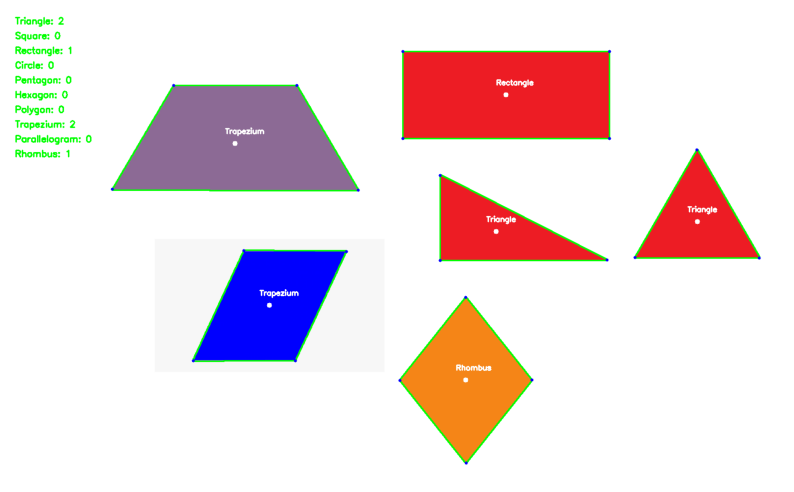

Detected shapes count:
Triangle: 2
Square: 0
Rectangle: 1
Circle: 0
Pentagon: 0
Hexagon: 0
Polygon: 0
Trapezium: 2
Parallelogram: 0
Rhombus: 1



In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def angle_between(v1, v2):
    v1 = v1.flatten()
    v2 = v2.flatten()
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_v1, unit_v2)
    angle = np.arccos(np.clip(dot_product, -1.0, 1.0))
    return np.degrees(angle)

def classify_quadrilateral(approx):
    # Get the side lengths
    side_lengths = [np.linalg.norm(approx[i] - approx[(i + 1) % 4]) for i in range(4)]
    # Get the angles
    angles = [angle_between(approx[i] - approx[(i - 1) % 4], approx[(i + 1) % 4] - approx[i]) for i in range(4)]
    
    # Sort side lengths and angles for easier comparison
    side_lengths.sort()
    angles = [angle % 180 for angle in angles]
    angles.sort()

    # Determine the type of quadrilateral
    if all(85 <= angle <= 95 for angle in angles):
        if np.allclose(side_lengths, side_lengths[0], atol=5):
            return "Square"
        else:
            return "Rectangle"
    elif np.allclose(side_lengths, side_lengths[0], atol=5):
        if not all(85 <= angle <= 95 for angle in angles):
            return "Rhombus"
        else:
            return "Square"
    elif len(set(np.round(angles, 1))) == 2:
        return "Parallelogram"
    else:
        return "Trapezium"

def detect_shapes(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or the path is incorrect")
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 240, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for contour in contours:
        # Approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.04 * peri, True)

        # If the shape has 3 vertices, it's a triangle
        if len(approx) == 3:
            shapes.append((contour, "Triangle", approx))
        # If the shape has 4 vertices, classify it further
        elif len(approx) == 4:
            shape_type = classify_quadrilateral(approx)
            shapes.append((contour, shape_type, approx))
        # If the shape has 5 vertices, it's a pentagon
        elif len(approx) == 5:
            shapes.append((contour, "Pentagon", approx))
        # If the shape has 6 vertices, it's a hexagon
        elif len(approx) == 6:
            shapes.append((contour, "Hexagon", approx))
        # If the shape has more than 6 vertices, it could be a circle or polygon
        else:
            # Use a simple heuristic: if the shape is very close to a circle
            area = cv2.contourArea(contour)
            (x, y), radius = cv2.minEnclosingCircle(contour)
            circle_area = np.pi * (radius ** 2)
            # Consider it a circle if the area difference is small and vertices are more than 8
            if abs(circle_area - area) < 0.5 * circle_area and len(approx) > 8:
                shapes.append((contour, "Circle", approx))
            else:
                shapes.append((contour, "Polygon", approx))

    return shapes, image

if __name__ == "__main__":
    image_path = "paint.png"  # Path to your image
    detected_shapes, image = detect_shapes(image_path)

    # Count shapes
    shape_counts = {"Triangle": 0, "Square": 0, "Rectangle": 0, "Circle": 0, "Pentagon": 0, "Hexagon": 0, "Polygon": 0, "Trapezium": 0, "Parallelogram": 0, "Rhombus": 0}
    for contour, shape, _ in detected_shapes:
        shape_counts[shape] += 1

    # Annotate and mark the shapes
    for i, (contour, shape, vertices) in enumerate(detected_shapes):
        # Get the bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
        
        # Draw the contour
        cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
        
        # Draw a mark at each vertex
        for vertex in vertices:
            x, y = vertex.ravel()
            cv2.circle(image, (x, y), 3, (255, 0, 0), -1)
        
        # Draw a mark at the centroid
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(image, (cX, cY), 5, (255, 255, 255), -1)
            
            # Draw the name of the shape at the centroid
            cv2.putText(image, shape, (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    # Print the counts of each shape
    shape_count_text = "Detected shapes count:\n"
    y0, dy = 30, 30
    for i, (shape, count) in enumerate(shape_counts.items()):
        text = f"{shape}: {count}"
        shape_count_text += text + "\n"
        cv2.putText(image, text, (10, y0 + i * dy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Display the annotated image with matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Display the shape count text
    print(shape_count_text)


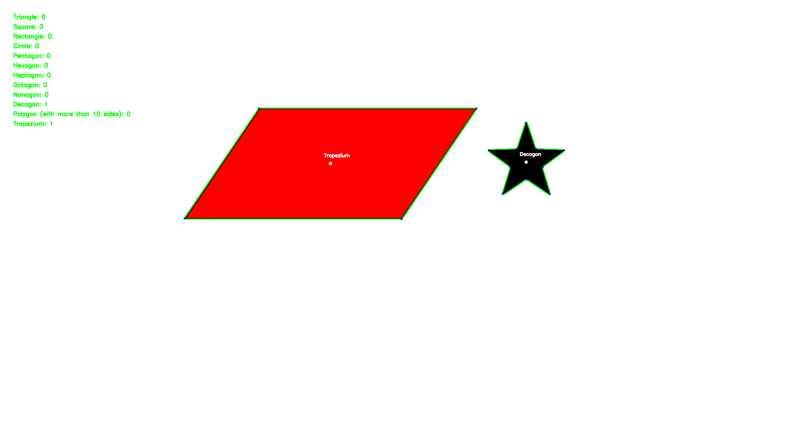

Detected shapes count:
Triangle: 0
Square: 0
Rectangle: 0
Circle: 0
Pentagon: 0
Hexagon: 0
Heptagon: 0
Octagon: 0
Nonagon: 0
Decagon: 1
Polygon (with more than 10 sides): 0
Trapezium: 1



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def angle_between(v1, v2):
    v1 = v1.flatten()
    v2 = v2.flatten()
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_v1, unit_v2)
    angle = np.arccos(np.clip(dot_product, -1.0, 1.0))
    return np.degrees(angle)

def classify_quadrilateral(approx):
    # Get the side lengths
    side_lengths = [np.linalg.norm(approx[i] - approx[(i + 1) % 4]) for i in range(4)]
    # Get the angles
    angles = [angle_between(approx[i] - approx[(i - 1) % 4], approx[(i + 1) % 4] - approx[i]) for i in range(4)]
    
    # Sort side lengths and angles for easier comparison
    side_lengths.sort()
    angles = [angle % 180 for angle in angles]
    angles.sort()

    # Determine the type of quadrilateral
    if all(85 <= angle <= 95 for angle in angles):
        if np.allclose(side_lengths, side_lengths[0], atol=5):
            return "Square"
        else:
            return "Rectangle"
    elif np.allclose(side_lengths, side_lengths[0], atol=5):
        if not all(85 <= angle <= 95 for angle in angles):
            return "Rhombus"
        else:
            return "Square"
    elif len(set(np.round(angles, 1))) == 2:
        return "Parallelogram"
    else:
        return "Trapezium"

def detect_shapes(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or the path is incorrect")
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 240, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for contour in contours:
        # Approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.04 * peri, True)
        num_vertices = len(approx)

        if num_vertices == 3:
            shapes.append((contour, "Triangle", approx))
        elif num_vertices == 4:
            shape_type = classify_quadrilateral(approx)
            shapes.append((contour, shape_type, approx))
        elif num_vertices == 5:
            shapes.append((contour, "Pentagon", approx))
        elif num_vertices == 6:
            shapes.append((contour, "Hexagon", approx))
        elif num_vertices == 7:
            shapes.append((contour, "Heptagon", approx))
        elif num_vertices == 8:
            shapes.append((contour, "Octagon", approx))
        elif num_vertices == 9:
            shapes.append((contour, "Nonagon", approx))
        elif num_vertices == 10:
            shapes.append((contour, "Decagon", approx))
        else:
            shapes.append((contour, "Polygon (with more than 10 sides)", approx))

    return shapes, image

if __name__ == "__main__":
    image_path = "parallelogram.png"  # Path to your image
    detected_shapes, image = detect_shapes(image_path)

    # Count shapes
    shape_counts = {"Triangle": 0, "Square": 0, "Rectangle": 0, "Circle": 0, "Pentagon": 0, "Hexagon": 0, "Heptagon": 0,
                "Octagon": 0, "Nonagon": 0, "Decagon": 0, "Polygon (with more than 10 sides)": 0, "Trapezium": 0}

    for contour, shape, _ in detected_shapes:
        shape_counts[shape] += 1

    # Annotate and mark the shapes
    for i, (contour, shape, vertices) in enumerate(detected_shapes):
        # Get the bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
        
        # Draw the contour
        cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
        
        # Draw a mark at each vertex
        for vertex in vertices:
            x, y = vertex.ravel()
            cv2.circle(image, (x, y), 3, (255, 0, 0), -1)
        
        # Draw a mark at the centroid
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(image, (cX, cY), 5, (255, 255, 255), -1)
            
            # Draw the name of the shape at the centroid
            cv2.putText(image, shape, (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    # Print the counts of each shape
    shape_count_text = "Detected shapes count:\n"
    y0, dy = 30, 30
    for i, (shape, count) in enumerate(shape_counts.items()):
        text = f"{shape}: {count}"
        shape_count_text += text + "\n"
        cv2.putText(image, text, (10, y0 + i * dy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Display the annotated image with matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Display the shape count text
    print(shape_count_text)
